## FCN全连接网络

In [11]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
%matplotlib inline

!pip -V

pip 23.2.1 from /home/jhr/anaconda3/envs/yolo/lib/python3.11/site-packages/pip (python 3.11)


In [12]:
# os.listdir(
#     "/home/jhr/Documents/data/location/annotations1/annotations/trimaps")[:1]
# img = tf.io.read_file(
#     "/home/jhr/Documents/data/location/annotations1/annotations/trimaps/leonberger_24.png")
# img = tf.image.decode_png(img)
# plt.imshow(img)
# img.shape
# img = tf.squeeze(img)  # 降维度
# img.shape
# plt.imshow(img)
# img2 = tf.io.read_file(
#     "/home/jhr/Documents/data/location/images1/images/leonberger_24.jpg")
# img2 = tf.image.decode_jpeg(img2)
# # plt.imshow(img2)

## 读取图片

In [13]:
images = glob.glob(
    #     'C:/Users/yeolume/source/data/图片定位与分割数据集/images/*.jpg')
    '/home/jhr/Program/TensorFlow/data/location/images1/images/*.jpg')
images.sort(key=lambda x: x.split('/')[-1].split('.jpg')[0])  # 排序
images[:5]

['/home/jhr/Program/TensorFlow/data/location/images1/images/Abyssinian_1.jpg',
 '/home/jhr/Program/TensorFlow/data/location/images1/images/Abyssinian_10.jpg',
 '/home/jhr/Program/TensorFlow/data/location/images1/images/Abyssinian_100.jpg',
 '/home/jhr/Program/TensorFlow/data/location/images1/images/Abyssinian_101.jpg',
 '/home/jhr/Program/TensorFlow/data/location/images1/images/Abyssinian_102.jpg']

In [14]:
anno = glob.glob(
    # 'C:/Users/yeolume/source/data/图片定位与分割数据集/annotations/trimaps/*.png')
    '/home/jhr/Program/TensorFlow/data/location/annotations1/annotations/trimaps/*.png')
anno.sort(key=lambda x: x.split('/')[-1].split('.png')[0])
anno[:5]

['/home/jhr/Program/TensorFlow/data/location/annotations1/annotations/trimaps/Abyssinian_1.png',
 '/home/jhr/Program/TensorFlow/data/location/annotations1/annotations/trimaps/Abyssinian_10.png',
 '/home/jhr/Program/TensorFlow/data/location/annotations1/annotations/trimaps/Abyssinian_100.png',
 '/home/jhr/Program/TensorFlow/data/location/annotations1/annotations/trimaps/Abyssinian_101.png',
 '/home/jhr/Program/TensorFlow/data/location/annotations1/annotations/trimaps/Abyssinian_102.png']

**乱序**

In [15]:
np.random.seed(2019)
index = np.random.permutation(len(images))

images = np.array(images)[index]
anno = np.array(anno)[index]
images[:1], anno[:1]

(array(['/home/jhr/Program/TensorFlow/data/location/images1/images/newfoundland_22.jpg'],
       dtype='<U92'),
 array(['/home/jhr/Program/TensorFlow/data/location/annotations1/annotations/trimaps/newfoundland_22.png'],
       dtype='<U110'))

In [16]:
dataset = tf.data.Dataset.from_tensor_slices((images, anno))

In [17]:
test_count = int(len(images) * 0.2)
train_count = len(images) - test_count

test_count, train_count

(1478, 5912)

In [18]:
data_train = dataset.skip(test_count)
data_test = dataset.skip(train_count)

In [19]:
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    return img

def normal_img(input_images, input_anno):
    input_images = tf.cast(input_images, tf.float32)
    input_images = input_images / 127.5 - 1

    input_anno -= 1
    return input_images, input_anno

In [20]:
@tf.function
def load_images(input_images_path, input_anno_path):
    input_image = read_jpg(input_images_path)
    input_anno = read_png(input_anno_path)
    input_image = tf.image.resize(input_image, (224, 224))
    input_anno = tf.image.resize(input_anno, (224, 224))
    return normal_img(input_image, input_anno)

**创建训练数据与测试数据**

In [21]:
data_train = data_train.map(load_images,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE
                            )

data_test = data_test.map(load_images,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE
                          )

In [22]:
batch_size_per_replica = 16  #单卡batch数量
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: %d' % strategy.num_replicas_in_sync)  # 輸出設備數量
batch_size = batch_size_per_replica * strategy.num_replicas_in_sync  #输出总batch

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [23]:
BATCH_SIZE = batch_size
data_train = data_train.repeat().shuffle(100).batch(BATCH_SIZE)
data_test = data_test.batch(BATCH_SIZE)

绘制图片

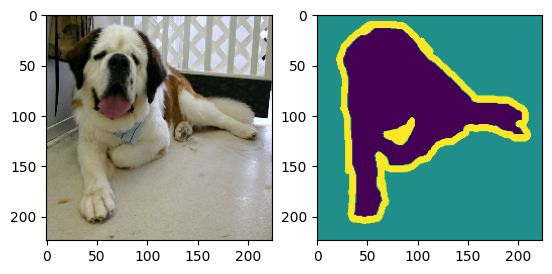

In [24]:
for img, anno in data_train.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(anno[0]))

**以下为单卡训练**

创建网络

In [ ]:
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        input_shape=(224, 224, 3),
                                        include_top=False
                                        )

conv_base.summary()

**创建多输出模型**

In [ ]:
layer_names = [
    'block5_conv3',
    'block4_conv3',
    'block3_conv3',
    'block5_pool'
]

layers_output = [conv_base.get_layer(
    layer_name).output for layer_name in layer_names]

In [ ]:
multi_out_model = tf.keras.models.Model(inputs=conv_base.input,
                                        outputs=layers_output
                                        )

In [ ]:
multi_out_model.trainable = True

In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
out_block5_conv3, out_block4_conv3, out_block3_conv3, out = multi_out_model(
    inputs)

In [ ]:
# 对out做上采样
x1 = tf.keras.layers.Conv2DTranspose(512, 3,
                                     strides=2,
                                     padding='same',
                                     activation='relu'
                                     )(out)
# 增加一层卷积，提高特征识别
x1 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x1)

In [ ]:
x1.shape

In [ ]:
x2 = tf.add(x1, out_block5_conv3)
# 对x2做上采样
x2 = tf.keras.layers.Conv2DTranspose(512, 3,
                                     strides=2,
                                     padding='same',
                                     activation='relu'
                                     )(x2)
# 增加一层卷积，提高特征识别
x2 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x2)

In [ ]:
x2.shape

In [ ]:
x3 = tf.add(x2, out_block4_conv3)
# 对x3做上采样
x3 = tf.keras.layers.Conv2DTranspose(256, 3,
                                     strides=2,
                                     padding='same',
                                     activation='relu'
                                     )(x3)
# 增加一层卷积，提高特征识别
x3 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x3)

In [ ]:
x3.shape

In [ ]:
x4 = tf.add(x3, out_block3_conv3)
# 对x4做上采样
x5 = tf.keras.layers.Conv2DTranspose(128, 3,
                                     strides=2,
                                     padding='same',
                                     activation='relu'
                                     )(x4)
# 增加一层卷积，提高特征识别
x5 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x5)

In [ ]:
x5.shape

In [ ]:
prediction = tf.keras.layers.Conv2DTranspose(3, 3,
                                             strides=2,
                                             padding='same',
                                             activation='softmax'
                                             )(x5)

In [ ]:
prediction.shape

In [ ]:
model = tf.keras.models.Model(
    inputs=inputs,
    outputs=prediction
)

In [ ]:
model.summary()

**单机多卡**

In [ ]:
with strategy.scope():
    conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                            input_shape=(224, 224, 3),
                                            include_top=False)

    layer_names = [
        'block5_conv3',
        'block4_conv3',
        'block3_conv3',
        'block5_pool'
    ]

    layers_output = [conv_base.get_layer(
        layer_name).output for layer_name in layer_names]

    multi_out_model = tf.keras.models.Model(inputs=conv_base.input,
                                            outputs=layers_output
                                            )
    multi_out_model.trainable = True
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    out_block5_conv3, out_block4_conv3, out_block3_conv3, out = multi_out_model(
        inputs)

    # 对out做上采样
    x1 = tf.keras.layers.Conv2DTranspose(512, 3,
                                         strides=2,
                                         padding='same',
                                         activation='relu'
                                         )(out)
    # 增加一层卷积，提高特征识别
    x1 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x1)

    x2 = tf.add(x1, out_block5_conv3)
    # 对x2做上采样
    x2 = tf.keras.layers.Conv2DTranspose(512, 3,
                                         strides=2,
                                         padding='same',
                                         activation='relu'
                                         )(x2)
    # 增加一层卷积，提高特征识别
    x2 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x2)

    x3 = tf.add(x2, out_block4_conv3)
    # 对x3做上采样
    x3 = tf.keras.layers.Conv2DTranspose(256, 3,
                                         strides=2,
                                         padding='same',
                                         activation='relu'
                                         )(x3)
    # 增加一层卷积，提高特征识别
    x3 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x3)

    x4 = tf.add(x3, out_block3_conv3)
    # 对x4做上采样
    x5 = tf.keras.layers.Conv2DTranspose(128, 3,
                                         strides=2,
                                         padding='same',
                                         activation='relu'
                                         )(x4)
    # 增加一层卷积，提高特征识别
    x5 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x5)

    prediction = tf.keras.layers.Conv2DTranspose(3, 3,
                                                 strides=2,
                                                 padding='same',
                                                 activation='softmax'
                                                 )(x5)

    #创建模型
    model = tf.keras.models.Model(
        inputs=inputs,
        outputs=prediction
    )

In [ ]:
model.summary()

**配置模型**

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

**训练模型**

In [ ]:
lr_reduce = keras.callbacks.ReduceLROnPlateau('val_loss', patience=3, factor=0.8, min_lr=0.0000001)

In [ ]:
history = model.fit(data_train,
                    epochs=100,
                    steps_per_epoch=train_count // BATCH_SIZE,
                    validation_data=data_test,
                    validation_steps=test_count // BATCH_SIZE,
                    callbacks=[lr_reduce]
                    )

In [ ]:
history.history.keys()

In [ ]:
plt.plot(history.epoch, history.history.get('acc'), label='acc', color='b')
plt.plot(history.epoch, history.history.get('val_acc'), label='val_acc', color='r')
plt.legend()

In [ ]:
num = 3
for img, mask in data_train.take(1):
    out_img = model.predict(img)
    out_img = tf.argmax(out_img, axis=-1)
    out_img = out_img[..., tf.newaxis]

    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i * num + 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        plt.subplot(num, 3, i * num + 2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num, 3, i * num + 3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(out_img[i]))

In [ ]:
model.save('/home/jhr/Program/TensorFlow/00-model/segmentation_v2.h5')

**tesging**

In [25]:
#加载模型
new_model = tf.keras.models.load_model('/home/jhr/Program/TensorFlow/00-model/segmentation_v2.h5')

2023-09-27 14:55:26.232127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8801


1/1 [==============================] - 4s 4s/step


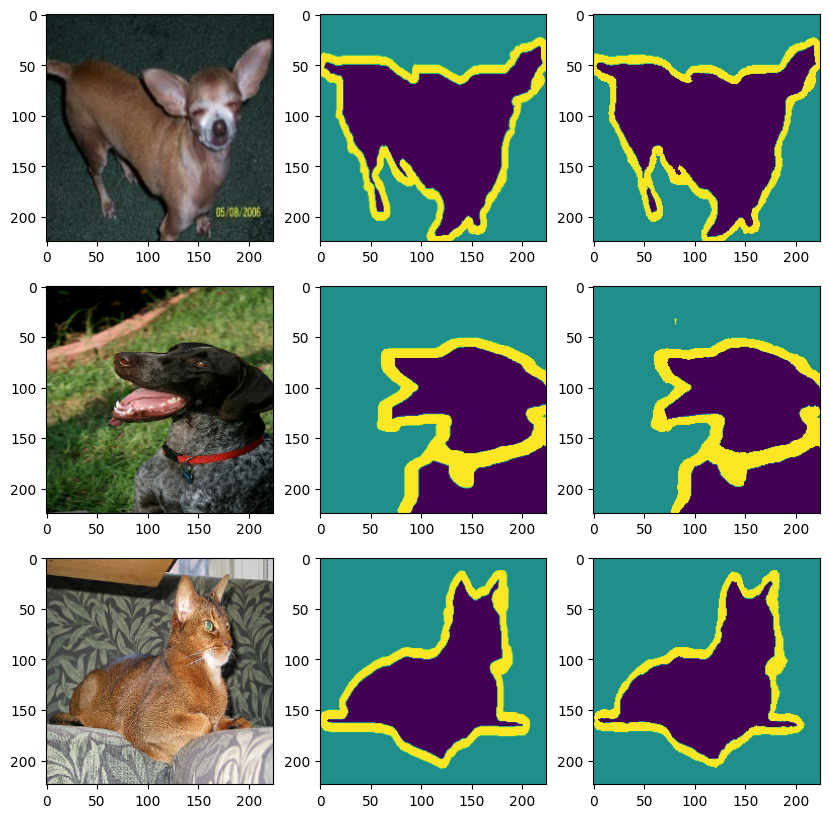

In [26]:
num = 3
for img, mask in data_train.take(1):
    out_img = new_model.predict(img)
    out_img = tf.argmax(out_img, axis=-1)
    out_img = out_img[..., tf.newaxis]

    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i * num + 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        plt.subplot(num, 3, i * num + 2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num, 3, i * num + 3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(out_img[i]))

In [ ]:
# new_model.summary()